In [41]:
import os
import numpy as np
import pickle
from lammps_implicit_der import SNAP
from lammps_implicit_der.systems import BCC, BCC_BINARY, BCC_BINARY_VACANCY, BCC_VACANCY, BCC_SIA, FromData, HCP
from lammps_implicit_der.tools import plot_tools, run_npt_implicit_derivative
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

comm = None

# Systems

In [42]:
bcc_pure = BCC(alat=3.18427, ncell_x=2, minimize=True, logname=None, data_path='./refs/', snapcoeff_filename = 'W.snapcoeff', verbose=False)
print(bcc_pure.energy)
print(bcc_pure.Ndesc)
print(bcc_pure.dU_dTheta @ bcc_pure.Theta)

-89.060889667491
55
-89.06088966749098


## Pure BCC lattice

In [43]:
bcc_pure = BCC(alat=3.18, ncell_x=2, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename = 'W.snapcoeff', verbose=False)
print(bcc_pure.energy)

-89.0555278168474


## BCC Vacancy

In [44]:
bcc_vac = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, logname=None, data_path='./refs/', snapcoeff_filename = 'W.snapcoeff', verbose=False)
print(bcc_vac.energy)
print(bcc_vac.Natom)

-80.36527467896518
15


## BCC Binary

In [45]:
bcc_binary = BCC_BINARY(alat=3.13, ncell_x=2, minimize=True, logname=None, data_path='./refs/', snapcoeff_filename = 'NiMo.snapcoeff', verbose=False)
print(bcc_binary.energy)
print(bcc_binary.Natom)
print(bcc_binary.species)
print(bcc_binary.Ndesc)

-122.76839711519715
16
[1 1 1 2 2 2 2 2 2 1 1 2 1 1 1 1]
30


## BCC Binary Vacancy

In [46]:
bcc_binary = BCC_BINARY_VACANCY(alat=3.13, ncell_x=2, minimize=True, logname=None, data_path='./refs/', snapcoeff_filename = 'NiMo.snapcoeff', verbose=False)
print(bcc_binary.energy)
print(bcc_binary.Natom)
print(bcc_binary.species)

-116.12471812826522
15
[1 1 1 2 2 2 2 2 2 1 1 2 1 1 1]


## Self-interstitial atom (SIA)

In [47]:
bcc_SIA = BCC_SIA(alat=3.18, ncell_x=2, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename = 'W.snapcoeff', verbose=False)
print(bcc_SIA.energy)
print(bcc_SIA.Natom)

-53.04187280340517
17


## BCC Vacancy

In [48]:
alat0 = 3.175
ncell_x = 2
system = BCC_VACANCY(alat=alat0, ncell_x=ncell_x, minimize=True, logname=None,
                    data_path='./refs/', snapcoeff_filename='W.snapcoeff', fix_box_relax=True, verbose=False)

alat = system.volume**(1/3) / ncell_x
print(alat)
print(system.energy)

3.163163264038606
-80.36528096803337


## FromData Class

1.9189360871738
-14.21539540264857
3


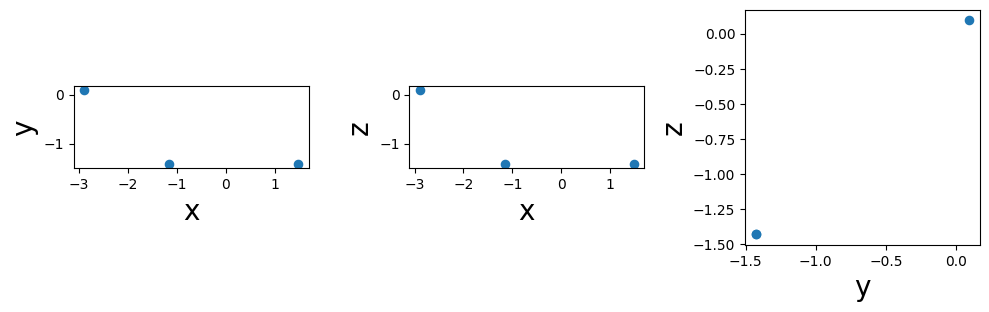

-14.215395402648571
3


In [49]:
alat0 = 3.175
ncell_x, ncell_y, ncell_z = 2, 1, 1
system = BCC_VACANCY(alat=alat0, ncell_x=ncell_x, ncell_y=ncell_y, ncell_z=ncell_z,
                     minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                    data_path='./refs/', snapcoeff_filename='W.snapcoeff', fix_box_relax=True, verbose=False)

alat = system.volume**(1/3) / ncell_x
print(alat)
print(system.energy)
print(system.Natom)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, system.X_coord.reshape(-1, 3), s=35)
plt.tight_layout()
plt.show()

system.write_data('test1.data')
system = FromData(datafile='test1.data', data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
os.remove('test1.data')
print(system.energy)
print(system.Natom)

### FromData with input script

In [50]:
alat0 = 3.175
ncell_x = 2
system = BCC(alat=alat0, ncell_x=2, ncell_y=1, ncell_z=1, minimize=True, logname=None,
             data_path='./refs/', snapcoeff_filename='W.snapcoeff', fix_box_relax=False, verbose=False)

print(system.energy)
print(system.Natom)

input_script = """
        atom_modify map array sort 0 0.0
        units metal
        boundary p p p
        lattice bcc 3.175 origin 0.01 0.01 0.01
        region C block 0 2 0 1 0 1 units lattice
        create_box 1 C
        create_atoms 1 region C
        mass * 184.
"""


system = FromData(input_script=input_script, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)

print(system.energy)
print(system.Natom)

-22.258870715899455
4
-22.258870715899455
4


## Hexagonal Close-Packed (HCP)

### Fixed a/c

In [51]:
alat_hcp = 2.84752278
hcp_W = HCP(alat=alat_hcp, ncell_x=1,
            minimize=True, fix_box_relax=False, #minimize_maxiter=500,
            data_path='./refs/', snapcoeff_filename='W.snapcoeff',
            verbose=False, comm=comm)

print(hcp_W.cell[0, 0])
print(hcp_W.cell[1, 1], alat_hcp * np.sqrt(3))
print(hcp_W.cell[2, 2], alat_hcp * np.sqrt(8/3))
print(hcp_W.energy)

2.84752278
4.932054130669774 4.932054130669774
4.649985227967626 4.649985227967626
-20.19323450167738


### Not fixed a/c

In [52]:
alat_hcp = 2.84752278
hcp_W_box_relax = HCP(alat=alat_hcp, ncell_x=1,
                      minimize=True, fix_box_relax=True, minimize_maxiter=1000, box_relax_iso=False,
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff',
                      verbose=True, comm=comm)

print(hcp_W_box_relax.cell[0, 0])
print(hcp_W_box_relax.cell[1, 1], alat_hcp * np.sqrt(3))
print(hcp_W_box_relax.cell[2, 2], alat_hcp * np.sqrt(8/3))
print(hcp_W_box_relax.energy)


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log none

Setting SNAP potential

                  SNAP coefficients for: W
                          quadraticflag: 0
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: True 

Minimization finished in 667 steps
Initial fmax: 3.275e-15, final fmax: 1.102e-13
Initial fnorm: 6.107e-15, final fnorm: 2.476e-13
Number of atoms: 4, largest force value: 1.102e-13, force norm: 2.476e-13
2.8054015915512567
4.85909809220136 4.932054130669774
4.958918214223956 4.649985227967626
-20.554598258667664


# Potential object

In [53]:
bcc_binary = BCC_BINARY(alat=3.13, specie_B_concentration=0.2, ncell_x=2, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename = 'NiMo.snapcoeff', verbose=False)
print(bcc_binary.pot.Theta_dict.keys())
print(bcc_binary.pot.Theta_dict['weights'], bcc_binary.pot.Theta_dict['radii'])
print(bcc_binary.pot.Theta_dict['Mo']['beta0'])
assert all( el in bcc_binary.pot.Theta_dict for el in ['Ni', 'Mo'])

dict_keys(['Ni', 'Mo', 'radii', 'weights'])
0.5 1.0 0.575 0.575
-11.1413071988


In [54]:
bcc_pure = BCC(alat=3.18427, ncell_x=2, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
coeffs = np.loadtxt('./refs/W.snapcoeff', skiprows=7)
print(coeffs.shape)
print(bcc_pure.pot.Theta_dict['W']['Theta'].shape)

(55,)
(55,)


# System properties

In [55]:
bcc_vacancy = BCC_VACANCY(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
print(bcc_vacancy.energy)
print(bcc_vacancy.dU_dTheta @ bcc_vacancy.Theta)
print(bcc_vacancy.X_coord)

print(bcc_vacancy.cell)
print(bcc_vacancy.inv_cell)

-2.79351789181571
-2.7935178918157098
[-1.54987 -1.54987 -1.54987]
[[3.163 0.    0.   ]
 [0.    3.163 0.   ]
 [0.    0.    3.163]]
[[0.31615555 0.         0.        ]
 [0.         0.31615555 0.        ]
 [0.         0.         0.31615555]]


## Minimum image convention

In [56]:
bcc_test = BCC(alat=3.163, ncell_x=1, minimize=False, logname=None,
               data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False, comm=comm)

X_coord_test = bcc_test.X_coord.copy()
X_coord_test[0] = 20.0
X_coord_test[3] = 50.0
bcc_test.X_coord = X_coord_test
print(bcc_test.X_coord)

[ 1.022    0.03163  0.03163 -0.608   -1.54987 -1.54987]


In [57]:
cell0 = bcc_vacancy.cell.copy()
strain = 1.5
cell_test = np.dot(cell0, np.eye(3) * strain)
bcc_vacancy.change_box(cell_test, update_system=True)
print(bcc_vacancy.cell)
bcc_vacancy.change_box(cell0, update_system=True)

[[4.7445 0.     0.    ]
 [0.     4.7445 0.    ]
 [0.     0.     4.7445]]


In [58]:
print(bcc_vacancy.volume)

31.644451746999998


In [97]:
bcc_vacancy = BCC_VACANCY(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
print(bcc_vacancy.dU_dTheta.shape)
print(bcc_vacancy.mixed_hessian.shape)

# save mixed hessian to npy
#np.save('test_system_props_dU_dTheta.npy', bcc_vacancy.dU_dTheta)
#np.save('test_system_props_mixed_hessian.npy', bcc_vacancy.mixed_hessian)

# load mixed hessian from npy
#mixed_hessian = np.load('test_system_props_mixed_hessian.npy')


(55,)
(55, 3)


In [60]:
bcc_binary = BCC_BINARY(alat=3.13, ncell_x=2, minimize=True, logname=None,
                        data_path='./refs/', snapcoeff_filename='NiMo.snapcoeff', verbose=False)

print(bcc_binary.dU_dTheta.shape)
print(bcc_binary.mixed_hessian.shape)
print(bcc_binary.species)
# save mixed hessian to npy
#np.save('test_system_props_dU_dTheta_binary.npy', bcc_binary.dU_dTheta)
#np.save('test_system_props_mixed_hessian_binary.npy', bcc_binary.mixed_hessian)

(30,)
(30, 48)
[1 1 1 2 2 2 2 2 2 1 1 2 1 1 1 1]


### Forces

In [61]:
bcc = BCC_VACANCY(alat=2.0, ncell_x=2, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False, comm=comm)
force_array = bcc.compute_forces()

print('Without dX')
print(np.max(force_array))
print(np.sum(np.abs(force_array)))

bcc_vacancy = BCC_VACANCY(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False, comm=comm)
dX_vector = np.zeros(bcc_vacancy.Natom*3)
dX_vector[0] = 0.1

print('With dX')
print(', '.join(map(str,bcc_vacancy.compute_forces(dX_vector=dX_vector))))

Without dX
25.543912547402932
613.0539011376676
With dX
1.1102230246251565e-16, 1.5959455978986625e-16, -8.502261009383781e-17


### Hessian

In [62]:
bcc_vacancy = BCC_VACANCY(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
print(bcc_vacancy.compute_hessian())
#np.save('test_system_props_hessian.npy', bcc_vacancy.hessian)

#h_test = np.load('test_system_props_hessian.npy')
#print(np.allclose(bcc_vacancy.hessian, h_test))

[[0.001 0.    0.   ]
 [0.    0.001 0.   ]
 [0.    0.    0.001]]


In [63]:
bcc_vacancy = BCC(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
X_coord_test = bcc_vacancy.X_coord.copy()
#X_coord_test[4] = 0.5
bcc_vacancy.scatter_coord(X_coord=X_coord_test)
bcc_vacancy.compute_D_dD()
bcc_vacancy.gather_D_dD()
print(bcc_vacancy.dU_dTheta.shape)
print(bcc_vacancy.mixed_hessian.shape)

# save mixed hessian to npy
#np.save('test_system_props_dU_dTheta.npy', bcc_vacancy.dU_dTheta)
#np.save('test_system_props_mixed_hessian.npy', bcc_vacancy.mixed_hessian)

(55,)
(55, 6)


In [64]:
bcc_vacancy = BCC(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
print(bcc_vacancy.dU_dTheta.shape)
print(bcc_vacancy.mixed_hessian.shape)

# save mixed hessian to npy
#np.save('test_system_props_dU_dTheta.npy', bcc_vacancy.dU_dTheta)
#np.save('test_system_props_mixed_hessian.npy', bcc_vacancy.mixed_hessian)

(55,)
(55, 6)


In [65]:
bcc_system_tmp = BCC(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
X_coord_test = bcc_vacancy.X_coord.copy()
X_coord_test[4] = 0.5
bcc_system_tmp.scatter_coord(X_coord=X_coord_test)
bcc_system_tmp.X_coord


array([ 0.03163,  0.03163,  0.03163, -1.54987,  0.5    , -1.54987])

### write_data()

In [66]:
bcc_system_tmp = BCC(alat=4.0, ncell_x=1, minimize=False, logname=None,
                         data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)

#bcc_system_tmp.write_data('bcc.data')
print(bcc_system_tmp.energy)

-4.628609827075535


In [67]:
#bcc_from_data = BCC(datafile='bcc.data', minimize=False, data_path='./refs', snapcoeff_filename='W.snapcoeff', logname=None, verbose=False)
#print(bcc_from_data.energy)

### pressure

In [68]:
bcc_system = BCC(alat=3.163, ncell_x=2, minimize=False, logname=None,
               data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
bcc_system.compute_virial()
bcc_system.gather_virial()
#print(bcc_system.virial)
bcc_system.get_pressure_from_virial()
print(bcc_system.pressure)

13.510282306996439


## SNAP Quadratic

In [69]:
bcc_system_qSNAP = BCC(alat=3.163, ncell_x=2, minimize=False, logname=None,
                     data_path='./refs/', snapcoeff_filename='W_qSNAP.snapcoeff', verbose=False, comm=comm)

print(bcc_system_qSNAP.pot.snapparam_dict['quadraticflag'])
print(len(bcc_system_qSNAP.pot.Theta_dict['W']['Theta']))
print(bcc_system_qSNAP.energy)
print(bcc_system_qSNAP.Ndesc)

1
1595
-133.8171661106873
1595


# Implicit derivative tests

In [70]:
def sort_coord(X_coord):

    X_round = np.round(X_coord, decimals=8)
    X_3D = X_round.reshape(-1, 3)
    idx_sort = np.lexsort((X_3D[:, 2], X_3D[:, 1], X_3D[:, 0]))

    flat_indices = np.concatenate([np.arange(i*3, i*3+3) for i in idx_sort])

    return flat_indices

True
(16, 3)
0
0.03162999999999996 0.03162999999999996 0.03163000000000006


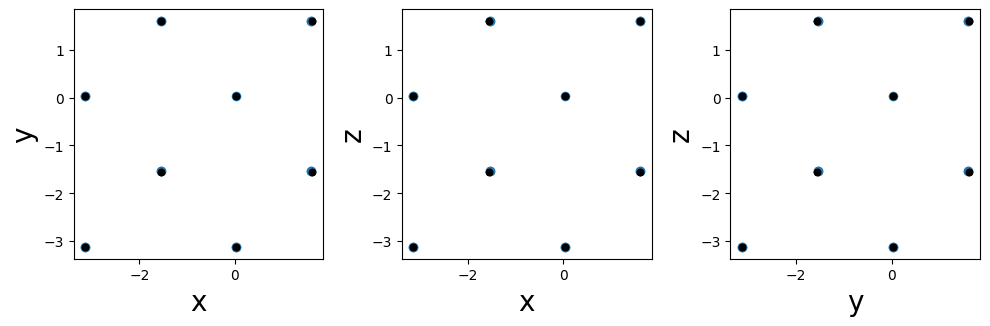

15


In [71]:
bcc_pure = BCC(alat=3.163, ncell_x=2, minimize=True, logname=None,
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
X_pure_3D = bcc_pure.X_coord.reshape(-1, 3)
X_target = np.array([0.0, 0.0, 0.0])
print(X_target.shape==(3,))
print((X_pure_3D-X_target).shape)
idx0 = np.argmin(np.linalg.norm(X_pure_3D-X_target, axis=1))
print(idx0)
print(bcc_pure.X_coord[idx0*3], bcc_pure.X_coord[idx0*3+1],bcc_pure.X_coord[idx0*3+2],)

bcc_vacancy = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_vacancy.X_coord.reshape(-1, 3), s=35)
plot_tools.plot_coords(axes, bcc_pure.X_coord.reshape(-1, 3), color='black', s=20)
plt.tight_layout()
plt.show()

print(bcc_vacancy.Natom)

## Inverse Hessian methods

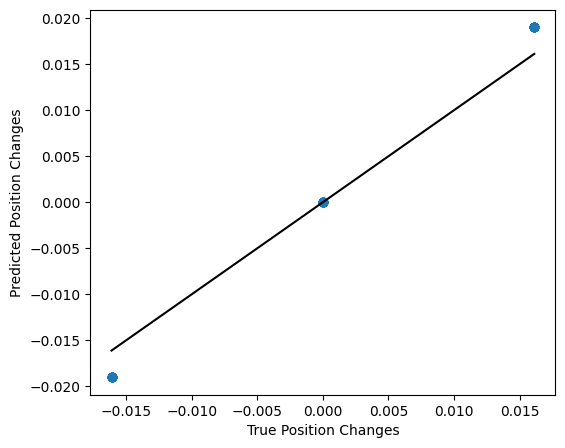

In [72]:
#der_method = 'inverse'
der_method = 'dense'
dX_dTheta = bcc_vacancy.implicit_derivative(method=der_method)

idx_sort = sort_coord(bcc_vacancy.X_coord)
dX_dTheta = dX_dTheta[:, idx_sort]

#np.save(f'test_impl_der_{der_method}.npy', dX_dTheta)
X0 = bcc_vacancy.X_coord.copy()[idx_sort]

bcc_vacancy_perturb = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                                 data_path='./refs', snapcoeff_filename='W_perturb.snapcoeff', snapparam_filename='W.snapparam', verbose=False)

dTheta = bcc_vacancy_perturb.Theta - bcc_vacancy.Theta

X_true = bcc_vacancy_perturb.X_coord.copy()[idx_sort]

dX_true = bcc_vacancy.minimum_image(X_true - X0)
dX_pred = dTheta @ dX_dTheta

dX_true -= dX_true.mean(axis=0)
dX_pred -= dX_pred.mean(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(dX_true, dX_pred, 'o')
ax.plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls='-', color='black')
ax.set_xlabel('True Position Changes')
ax.set_ylabel('Predicted Position Changes')
plt.show()

## Sparse method

dX_dTheta.shape=(55, 45)


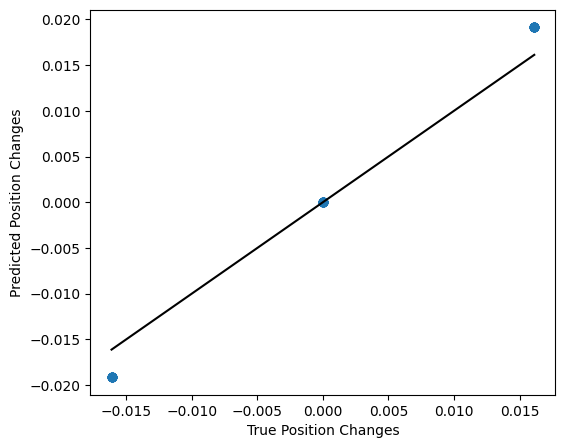

In [73]:
der_method = 'sparse'
dX_dTheta = bcc_vacancy.implicit_derivative(method=der_method, alpha0=1e-4, adaptive_alpha=False, maxiter=20)

idx_sort = sort_coord(bcc_vacancy.X_coord)
dX_dTheta = dX_dTheta[:, idx_sort]

#np.save(f'test_impl_der_{der_method}.npy', dX_dTheta)
X0 = bcc_vacancy.X_coord.copy()[idx_sort]

bcc_vacancy_perturb = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                                 data_path='./refs', snapcoeff_filename='W_perturb.snapcoeff', snapparam_filename='W.snapparam', verbose=False)

dTheta = bcc_vacancy_perturb.Theta - bcc_vacancy.Theta

X_true = bcc_vacancy_perturb.X_coord.copy()[idx_sort]

dX_true = bcc_vacancy.minimum_image(X_true - X0)
dX_pred = dTheta @ dX_dTheta

dX_true -= dX_true.mean(axis=0)
dX_pred -= dX_pred.mean(axis=0)
print(f'{dX_dTheta.shape=}')
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(dX_true, dX_pred, 'o')
ax.plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls='-', color='black')
ax.set_xlabel('True Position Changes')
ax.set_ylabel('Predicted Position Changes')
plt.show()

## Hessian mask

>>>Radius mask. Center of the mask: [0. 0. 0.], with radius of 2.7 A
>>>Number of elements in the mask: 12 out of 45 (26.7%)
>>>Number of atoms in the mask: 4 out of 15
np.sum(hess_mask)=12
np.sum(hess_mask_3D)=4
(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 33, 34, 35]),)


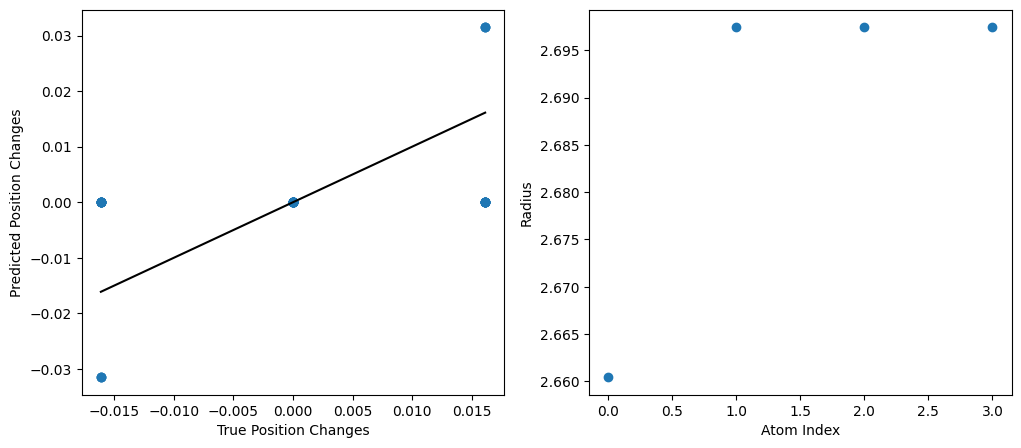

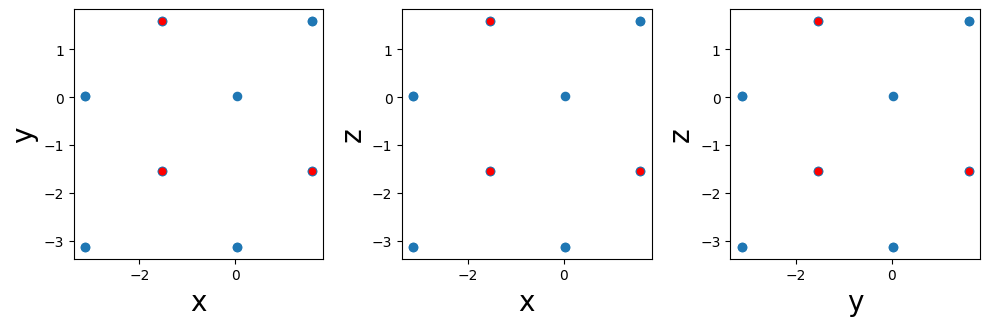

In [74]:
from lammps_implicit_der.tools import generate_masks

X_coord = bcc_vacancy.X_coord.copy()
idx_sort = sort_coord(X_coord)
X_coord = X_coord[idx_sort]
X_coord_3D = X_coord.reshape(-1, 3)

hess_mask, hess_mask_3D = generate_masks.generate_mask_radius(X_coord, radius=2.7,
                                                  center_coord=np.array([0.0, 0.0, 0.0]),
                                                  comm=comm)

print(f'{np.sum(hess_mask)=}')
print(f'{np.sum(hess_mask_3D)=}')

dX_dTheta = bcc_vacancy.implicit_derivative(method='dense', hess_mask=hess_mask)
dX_dTheta = dX_dTheta[:, idx_sort]
dX_pred = dTheta @ dX_dTheta

#np.save(f'test_impl_der_dense_hess_mask.npy', dX_dTheta)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(dX_true, dX_pred, 'o')
axes[0].plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls='-', color='black')
axes[0].set_xlabel('True Position Changes')
axes[0].set_ylabel('Predicted Position Changes')

radii = np.linalg.norm(X_coord_3D[hess_mask_3D, :], axis=1)
axes[1].plot(radii, 'o')
axes[1].set_xlabel('Atom Index')
axes[1].set_ylabel('Radius')

print(np.where(hess_mask))

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, X_coord.reshape(-1, 3), s=35)
plot_tools.plot_coords(axes, X_coord_3D[hess_mask_3D, :], color='red', s=20)
plt.tight_layout()
plt.show()

## Energy method

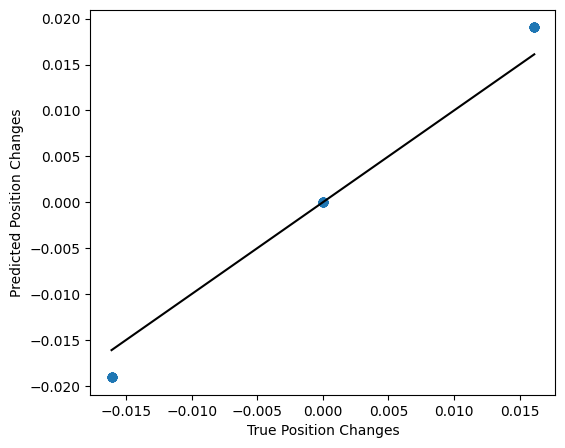

In [75]:
#min_style = 'sd'
min_style = 'cg'
dX_dTheta = bcc_vacancy.implicit_derivative(method='energy', adaptive_alpha=True, min_style=min_style, alpha0=1e-6, ftol=1e-6, maxiter=100)

idx_sort = sort_coord(bcc_vacancy.X_coord)
dX_dTheta = dX_dTheta[:, idx_sort]

#dX_dTheta = dX_dTheta.reshape(bcc_vacancy.Ndesc, bcc_vacancy.Natom, 3)
#dX_dTheta = dX_dTheta[:, sort_coord(bcc_vacancy.X_coord), :]
#dX_dTheta = dX_dTheta.reshape(bcc_vacancy.Ndesc, bcc_vacancy.Natom*3)

#np.save(f'test_impl_der_energy_{min_style}.npy', dX_dTheta)

X0 = bcc_vacancy.X_coord.copy()[idx_sort]

bcc_vacancy_perturb = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                                 data_path='./refs', snapcoeff_filename='W_perturb.snapcoeff', snapparam_filename='W.snapparam', verbose=False)

dTheta = bcc_vacancy_perturb.Theta - bcc_vacancy.Theta

X_true = bcc_vacancy_perturb.X_coord.copy()[idx_sort]

dX_true = bcc_vacancy.minimum_image(X_true - X0)
dX_pred = dTheta @ dX_dTheta

dX_true -= dX_true.mean(axis=0)
dX_pred -= dX_pred.mean(axis=0)

#np.save(f'test_impl_der_energy_dX_{min_style}.npy', dX_pred)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(dX_true, dX_pred, 'o')
ax.plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls='-', color='black')
ax.set_xlabel('True Position Changes')
ax.set_ylabel('Predicted Position Changes')
plt.show()


## 211 bcc for faster run with fire

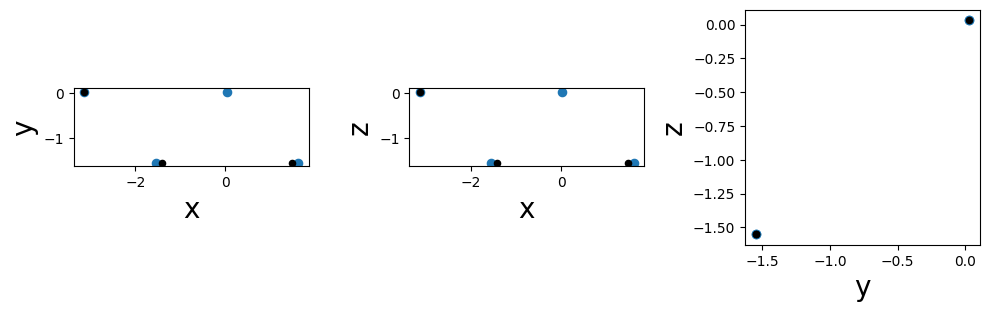

15


In [76]:
bcc_pure_211 = BCC(alat=3.163, ncell_x=2, ncell_y=1, ncell_z=1, minimize=True, logname=None,
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
bcc_vacancy_211 = BCC_VACANCY(alat=3.163, ncell_x=2, ncell_y=1, ncell_z=1, minimize=True, logname=None,  del_coord=[0.0, 0.0, 0.0],
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_pure_211.X_coord.reshape(-1, 3), s=35)
plot_tools.plot_coords(axes, bcc_vacancy_211.X_coord.reshape(-1, 3), color='black', s=20)
plt.tight_layout()
plt.show()

print(bcc_vacancy.Natom)

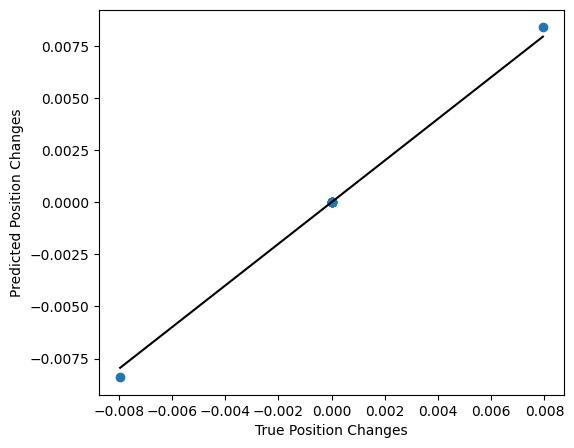

In [77]:
min_style = 'fire'
#min_style = 'cg'
dX_dTheta = bcc_vacancy_211.implicit_derivative(method='energy', adaptive_alpha=True, min_style=min_style, alpha0=1e-3, ftol=1e-7, maxiter=50)
idx_sort = sort_coord(bcc_vacancy_211.X_coord)
X0 = bcc_vacancy_211.X_coord.copy()[idx_sort]
dX_dTheta = dX_dTheta[:, idx_sort]

#np.save(f'test_impl_der_energy_{min_style}.npy', dX_dTheta)

bcc_vacancy_211_perturb = BCC_VACANCY(alat=3.163, ncell_x=2, ncell_y=1, ncell_z=1, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                                 data_path='./refs', snapcoeff_filename='W_perturb2.snapcoeff', snapparam_filename='W.snapparam', verbose=False)

X_true = bcc_vacancy_211_perturb.X_coord.copy()[idx_sort]

dX_true = bcc_vacancy_211.minimum_image(X_true - X0)

dTheta = bcc_vacancy_211_perturb.Theta - bcc_vacancy_211.Theta
dX_pred = dTheta @ dX_dTheta

dX_true -= dX_true.mean(axis=0)
dX_pred -= dX_pred.mean(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(dX_true, dX_pred, 'o')
ax.plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls='-', color='black')
ax.set_xlabel('True Position Changes')
ax.set_ylabel('Predicted Position Changes')
plt.show()

# Homogeneous implicit derivative (BCC)

In [78]:
create_new_Theta = False

if create_new_Theta:
    Theta_ens_path = '/Users/imaliyov/run/potential-perturbation/vacancy_formation/ncell_x_2_dense/Theta_ens.pkl'
    with open(Theta_ens_path, 'rb') as file:
        Theta_ens = pickle.load(file)

    sample = 1

    delta = 100.0

    Theta_perturb = Theta_ens['Theta_mean'] + delta * (Theta_ens['Theta_ens_list'][sample] - Theta_ens['Theta_mean'])
    pot = SNAP.from_files('W.snapcoeff', data_path='./refs', comm=None)
    pot.Theta_dict['W']['Theta'] = Theta_perturb
    #pot.to_files(path='.', snapcoeff_filename='W_perturb3.snapcoeff')
    pot.to_files(path='.', snapcoeff_filename='W_perturb4.snapcoeff')

In [79]:
bcc_vacancy = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False, comm=None)

bcc_vacancy_perturb = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, fix_box_relax=True,
                                 logname=None, del_coord=[0.0, 0.0, 0.0],
                                 data_path='./refs', snapcoeff_filename='W_perturb3.snapcoeff', snapparam_filename='W.snapparam', verbose=False)
dTheta = bcc_vacancy_perturb.Theta - bcc_vacancy.Theta

volume0 = bcc_vacancy.volume
L0 = volume0**(1.0/3.0)
cell0 = bcc_vacancy.cell.copy()

volume_true = bcc_vacancy_perturb.volume
L_true = volume_true**(1.0/3.0)

In [80]:
#dL_dTheta = bcc_vacancy.implicit_derivative_hom_iso(method='dVirial')
#dL_dTheta = bcc_vacancy.implicit_derivative_hom_iso(method='d2Desc')

dStrain_dTheta = bcc_vacancy.implicit_derivative_hom_iso(delta_Strain=1e-5)
Strain_pred = dTheta @ dStrain_dTheta

Strain_true = (L_true - L0) / L0

cell_pred = cell0 @ (np.eye(3) * (1.0 + Strain_pred))

volume_pred = np.linalg.det(cell_pred)

print(f'{dStrain_dTheta[0]=}')
print(f'{Strain_pred=:.8f}')
print(f'{Strain_true=:.8f}')
print(f'{volume0=:.8f}')
print(f'{volume_true=:.8f}')
print(f'{volume_pred=:.8f}')

dStrain_dTheta[0]=5.756017007113002
Strain_pred=-0.00637293
Strain_true=-0.00667573
volume0=253.15561398
volume_true=248.11939053
volume_pred=248.34636447


## Homogeneous derivative (HCP)

In [116]:
alat_hcp = 2.89082627

hcp_W = HCP(alat=alat_hcp, ncell_x=1,
            minimize=True, fix_box_relax=True, logname=None,
            data_path='./refs/', snapcoeff_filename='W.snapcoeff',
            verbose=True, comm=comm)


print(f'{hcp_W.cell=}')
print(f'{hcp_W.energy=}')


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log none

Setting SNAP potential

                  SNAP coefficients for: W
                          quadraticflag: 0
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: True 

Minimization finished in 1 steps
Initial fmax: 6.550e-15, final fmax: 4.663e-15
Initial fnorm: 8.601e-15, final fnorm: 7.829e-15
Number of atoms: 4, largest force value: 4.663e-15, force norm: 7.829e-15
hcp_W.cell=array([[2.89082627, 0.        , 0.        ],
       [0.        , 5.00705798, 0.        ],
       [0.        , 0.        , 4.72069953]])
hcp_W.energy=-20.321456299855154


In [123]:

alat_hcp = 2.89082627

hcp_W = HCP(alat=alat_hcp, ncell_x=1,
            minimize=True, fix_box_relax=False, logname=None,
            data_path='./refs/', snapcoeff_filename='W.snapcoeff',
            verbose=False, comm=comm)

hcp_W_perturb = HCP(alat=alat_hcp, ncell_x=1,
                    minimize=True, fix_box_relax=False, logname=None,
                    data_path='./refs/', snapcoeff_filename='W_perturb2.snapcoeff', snapparam_filename='W.snapparam',
                    verbose=False, comm=comm)


cell0 = hcp_W.cell.copy()
volume0 = hcp_W.volume

dTheta = hcp_W_perturb.Theta - hcp_W.Theta

dStrain_dTheta = hcp_W.implicit_derivative_hom_iso()

Strain_pred = dTheta @ dStrain_dTheta
cell_pred = cell0 @ (np.eye(3) * (1.0 + Strain_pred))
volume_pred = np.linalg.det(cell_pred)

print(f'{Strain_pred=}')
print(f'{volume0=}')
print(f'{volume_pred=}')

hcp_W_true = HCP(alat=alat_hcp, ncell_x=1,
                 minimize=True, fix_box_relax=True, logname=None,
                 data_path='./refs/', snapcoeff_filename='W_perturb2.snapcoeff', snapparam_filename='W.snapparam',
                 verbose=False, comm=comm)

volume_true = hcp_W_true.volume
print(f'{volume_true=}')
print(f'{hcp_W.energy=}')
print(f'{hcp_W_perturb.energy=}')
print(f'{hcp_W_true.energy=}')

Strain_pred=0.00011244071585598834
volume0=68.32992931626956
volume_pred=68.35298110653517
volume_true=68.35272728445175
hcp_W.energy=-20.321456299855143
hcp_W_perturb.energy=-20.366610369536595
hcp_W_true.energy=-20.366616299814833


# NPT minimization

In [81]:
from lammps_implicit_der.tools import compute_energy_volume

## Energy-volume

In [82]:
bcc_vacancy = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False, comm=comm)

epsilon_array = np.linspace(-0.05, 0.05, 3)
en_vol_dict = compute_energy_volume(bcc_vacancy, epsilon_array)
print(en_vol_dict.keys())

dict_keys(['energy_array', 'volume_array', 'virial_array', 'pressure_array', 'descriptor_array'])


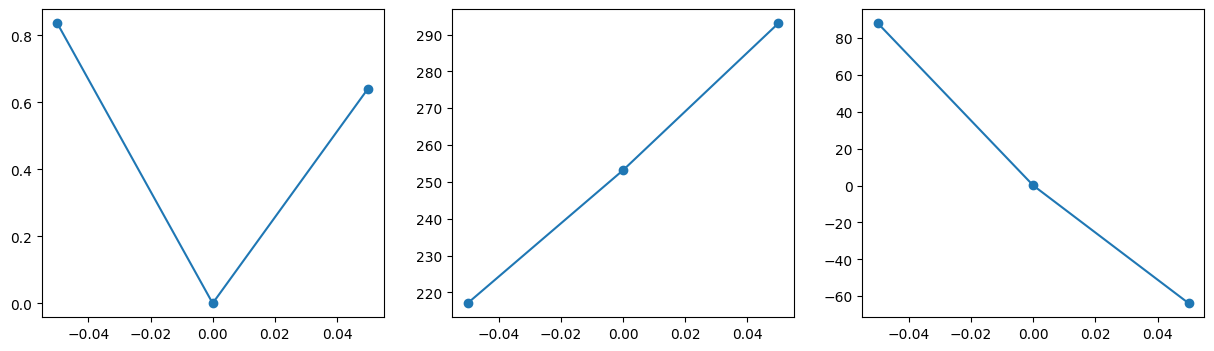

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(epsilon_array, en_vol_dict['energy_array'], 'o-', label='Energy')
axes[1].plot(epsilon_array, en_vol_dict['volume_array'], 'o-', label='Volume')
axes[2].plot(epsilon_array, en_vol_dict['pressure_array'], 'o-', label='Pressure')

plt.show()

In [84]:
def print_desired_array(array, name):
    print(f'{name} = np.array([{", ".join([f"{x:.10f}" for x in array])}])')

print_desired_array(en_vol_dict['energy_array'], 'energy_array_desired')
print_desired_array(en_vol_dict['volume_array'], 'volume_array_desired')
print_desired_array(en_vol_dict['pressure_array'], 'pressure_array_desired')



energy_array_desired = np.array([0.8362907116, 0.0000000000, 0.6414094626])
volume_array_desired = np.array([217.0492945327, 253.1556139760, 293.0592676290])
pressure_array_desired = np.array([88.0973712299, 0.0812326755, -63.8315221331])


## NPT minimization function

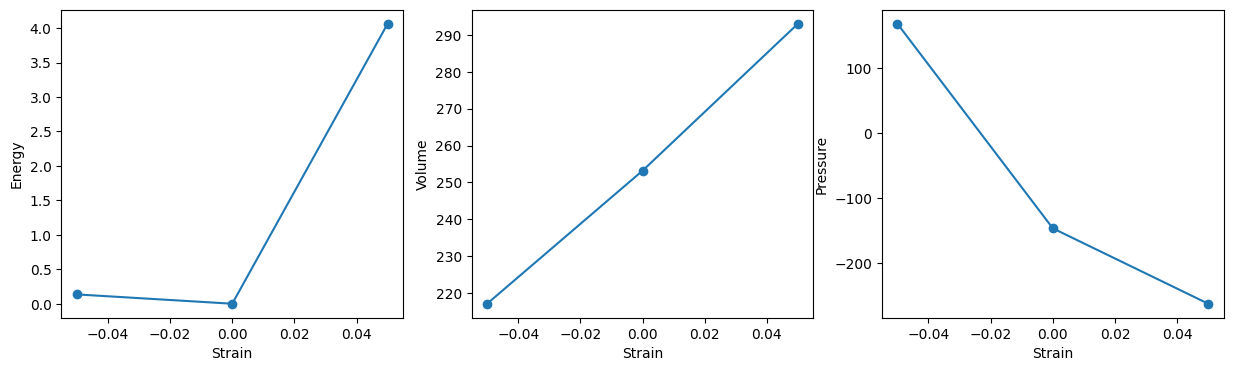

In [85]:
# Read potential
pot_perturb = SNAP.from_files('W_perturb.snapcoeff', data_path='./refs', comm = comm)
Theta_perturb = pot_perturb.Theta_dict['W']['Theta'].copy()

epsilon_array = np.linspace(-0.05, 0.05, 3)
bcc_vac = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, logname=None, data_path='./refs/', snapcoeff_filename='W_perturb.snapcoeff', verbose=False, comm=comm)
en_vol_dict = compute_energy_volume(bcc_vac, epsilon_array)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(epsilon_array, en_vol_dict['energy_array'], 'o-', label='Energy')
axes[1].plot(epsilon_array, en_vol_dict['volume_array'], 'o-', label='Volume')
axes[2].plot(epsilon_array, en_vol_dict['pressure_array'], 'o-', label='Pressure')
axes[0].set_xlabel('Strain')
axes[1].set_xlabel('Strain')
axes[2].set_xlabel('Strain')
axes[0].set_ylabel('Energy')
axes[1].set_ylabel('Volume')
axes[2].set_ylabel('Pressure')

plt.show()

In [86]:
alat = 3.163
ncell_x = 2
snapcoeff_filename = 'W.snapcoeff'
snapparam_filename = 'W.snapparam'
pot_perturb = SNAP.from_files('W_perturb3.snapcoeff', snapparam_filename='W.snapparam', data_path='./refs', comm = comm)
Theta_perturb = pot_perturb.Theta_dict['W']['Theta'].copy()

bcc_vac = BCC_VACANCY(alat=alat, ncell_x=ncell_x, minimize=True, logname=None, data_path='./refs/',
                     snapcoeff_filename=snapcoeff_filename, verbose=False, comm=comm, del_coord=[0.0, 0.0, 0.0])

dX_dTheta_vac_inhom = bcc_vac.implicit_derivative(method='dense')
dX_dTheta_vac_inhom = dX_dTheta_vac_inhom[:, sort_coord(bcc_vac.X_coord)]
dStrain_dTheta = bcc_vac.implicit_derivative_hom_iso(delta_Strain=1e-5)

res_dict = run_npt_implicit_derivative(BCC_VACANCY, alat, ncell_x, Theta_perturb,
                                       snapcoeff_filename, snapparam_filename,
                                       dX_dTheta_vac_inhom, dStrain_dTheta, data_path='./refs', comm=comm, log_box_relax=None, log_pred=None, del_coord=[0.0, 0.0, 0.0])

In [87]:
print(dStrain_dTheta[0])

5.756017007113002


In [88]:
print(dTheta)

[ 3.72970943e-02 -1.57833896e-01  8.81090315e-01  8.76888731e-02
  2.13228494e-01  1.71971473e-02  2.20780766e-01  8.97908299e-03
  3.16411148e-01  3.77721715e-01  3.77420622e-01  2.06028093e-01
  1.43770697e-01 -1.18563117e-02  3.16668417e-01  2.64575582e-01
  1.77760498e-01  2.57271314e-01  1.56652930e-01  4.99221285e-02
  3.28953428e-02  1.11550481e-02 -1.60895696e-02  2.43425636e-01
  5.80687085e-02  2.92153449e-02  8.28981029e-03  8.73691168e-02
  6.80172576e-02  3.27655801e-03 -3.95089034e-02  6.36006450e-04
 -1.02111231e-02  1.83271954e-01 -5.46531416e-02 -6.56885221e-02
  1.40860200e-02 -1.45050358e-03  2.10133068e-02 -4.67309638e-02
 -1.57910051e-02 -1.39306490e-02 -4.04454173e-03  8.87623140e-02
 -6.32723449e-02  2.35233239e-02  1.66419442e-02 -3.46422176e-02
 -1.57175088e-02 -3.31841781e-02 -1.98926304e-03 -6.77326553e-02
  1.17081208e-02  2.40471164e-02 -1.18369661e-02]


In [89]:
print(res_dict['volume_pred'])

248.34636447004732


In [90]:
def print_desired_quantity(d, k):
    print(f'{k}_desired = {d[k]:.10f}')

for k in ['volume0', 'volume_true', 'volume_pred', 'volume_pred_full',
          'energy0', 'energy_true', 'energy_pred0', 'energy_hom_pred',
          'energy_inhom_pred', 'energy_full_pred',
          'coord_error_full', 'coord_error_hom', 'coord_error_inhom', 'coord_error0']:
    print_desired_quantity(res_dict, k)

volume0_desired = 253.1556139760
volume_true_desired = 248.1193905314
volume_pred_desired = 248.3463644700
volume_pred_full_desired = 248.3463644700
energy0_desired = -80.3652746790
energy_true_desired = -151.1767062076
energy_pred0_desired = -151.0473247287
energy_hom_pred_desired = -151.1509332806
energy_inhom_pred_desired = -151.0344359304
energy_full_pred_desired = -151.1369100081
coord_error_full_desired = 0.0582562927
coord_error_hom_desired = 0.0436734382
coord_error_inhom_desired = 0.0714324920
coord_error0_desired = 0.0628672488


# Inverse design

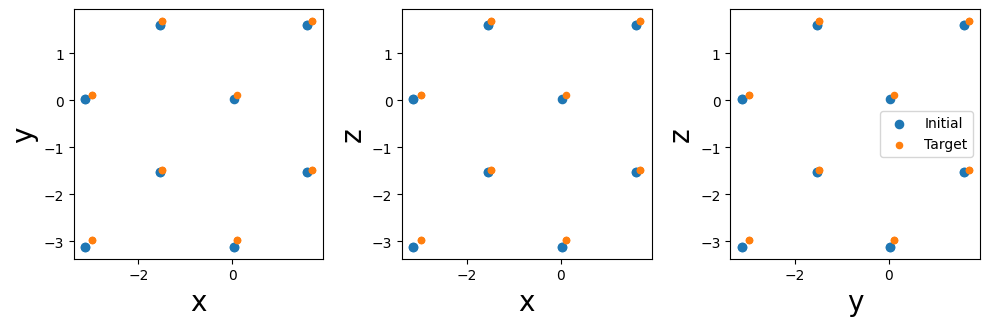

In [91]:
bcc_vacancy = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False, comm=None)

bcc_vacancy_target = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, fix_box_relax=True,
                                 logname=None, del_coord=[0.0, 0.0, 0.0],
                                 data_path='./refs', snapcoeff_filename='W_perturb4.snapcoeff', snapparam_filename='W.snapparam', verbose=False)

X_start = bcc_vacancy.X_coord.copy()
X_target = bcc_vacancy_target.X_coord.copy()
X_target = X_start.copy() + bcc_vacancy.minimum_image(X_target-X_start)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_vacancy.X_coord.copy().reshape(-1, 3), s=35, label='Initial')
plot_tools.plot_coords(axes, bcc_vacancy_target.X_coord.copy().reshape(-1, 3), s=20, label='Target')
plt.tight_layout()
plt.show()

In [92]:
print(X_target.shape)

(45,)


In [93]:
comm = None
from lammps_implicit_der.tools import error_tools

bcc_start = BCC_VACANCY(alat=3.163, ncell_x=2, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False, comm=None)

bcc_vacancy_final, minim_dict = error_tools.minimize_loss(
                                    bcc_start,
                                    X_target,
                                    'W',
                                    comm=comm,
                                    step=2e-3,
                                    adaptive_step=True,
                                    maxiter=10,
                                    error_tol=5e-2,
                                    der_method='dense',
                                    verbosity=0,
                                    minimize_at_iters=False,
                                    apply_hard_constraints=False,
                                    )

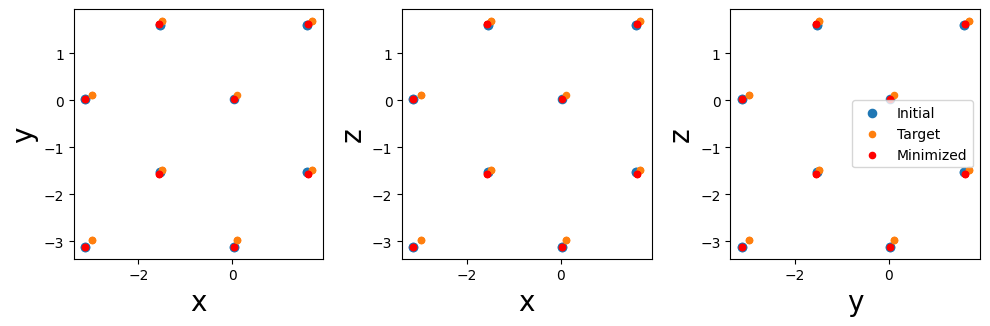

In [94]:

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_vacancy.X_coord.copy().reshape(-1, 3), s=35, label='Initial')
plot_tools.plot_coords(axes, bcc_vacancy_target.X_coord.copy().reshape(-1, 3), s=20, label='Target')
plot_tools.plot_coords(axes, bcc_vacancy_final.X_coord.copy().reshape(-1, 3), color='red', s=20, label='Minimized')
plt.tight_layout()
plt.show()

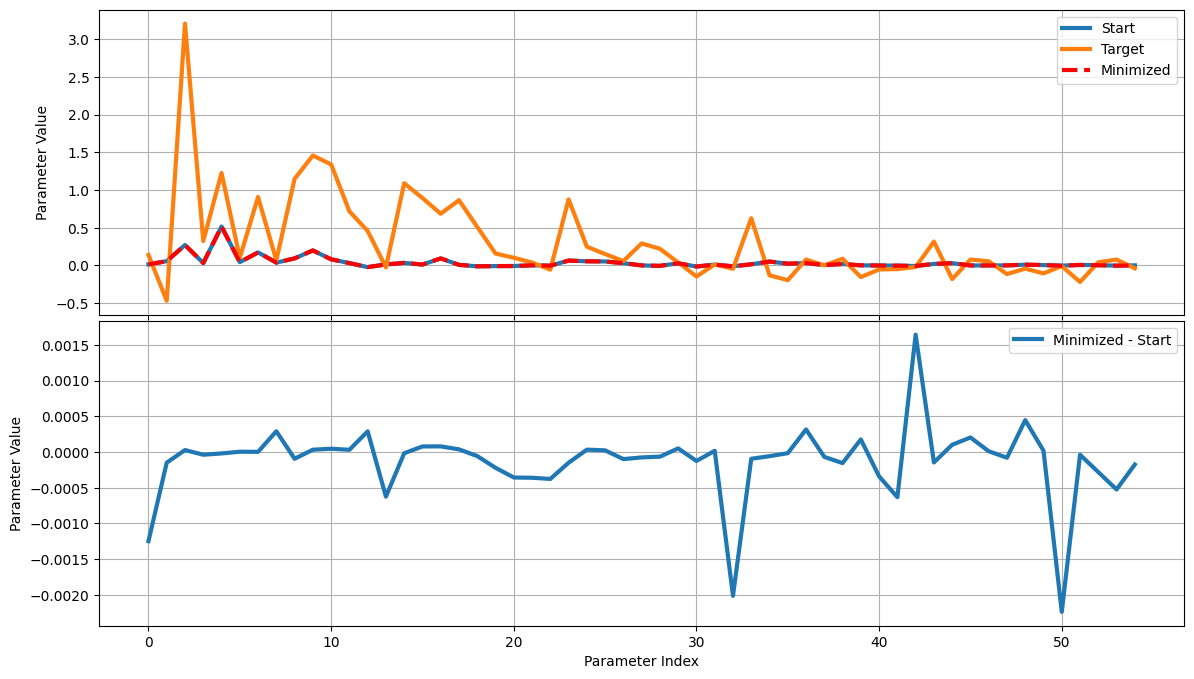

In [95]:
Theta_start = bcc_vacancy.pot.Theta_dict['W']['Theta']
Theta_target = bcc_vacancy_target.pot.Theta_dict['W']['Theta']
Theta_minimized = bcc_vacancy_final.pot.Theta_dict['W']['Theta']

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
plt.subplots_adjust(hspace=0.02)
axes[0].plot(Theta_start, label='Start', lw=3)
axes[0].plot(Theta_target, label='Target', lw=3)
axes[0].plot(Theta_minimized, label='Minimized', lw=3, ls='--', color='red')

axes[1].set_xlabel('Parameter Index')
axes[1].plot(Theta_minimized - Theta_start, label='Minimized - Start', lw=3)

for ax in axes:
    ax.grid()
    ax.set_ylabel('Parameter Value')
    ax.legend()

plt.show()

In [96]:
print(f'numiter_desired = {minim_dict["numiter"]}')
print(f'error_array_desired = np.array([{", ".join([f"{x:.10f}" for x in minim_dict["error_array"]])}])')
print(f'loop_completed_desired = {minim_dict["loop_completed"]}')
print(f'converged_desired = {minim_dict["converged"]}')
print(f'step_desired = {minim_dict["iter"][1]["step"]:.10f}')

numiter_desired = 1
error_array_desired = np.array([0.0325912346, 0.0256618410])
loop_completed_desired = True
converged_desired = True
step_desired = 0.0011412791
